# Explore gradient descent autocorelation

## Test sgd on toy dataset

In [3]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
Y = np.array([1, 1, 2, 2])
# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(loss='squared_error',max_iter=1000, tol=1e-3, verbose=0, learning_rate='optimal', eta0=0.1))
clf.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(eta0=0.1, loss='squared_error'))])

In [4]:
clf['sgdclassifier'].weights_sequence[:clf['sgdclassifier'].n_iter_*len(X), :]

array([[ 6.33088621e-01,  1.00100100e+00],
       [-3.35872506e+01, -2.60520521e+01],
       [ 1.01368756e+02,  1.87359157e+02],
       [-6.91203767e+03, -5.35711845e+03],
       [ 8.79709027e+04,  1.44671538e+05],
       [-4.96484093e+06, -3.84985213e+06],
       [ 1.48116494e+07,  2.74235051e+07],
       [-1.00834643e+09, -7.81438361e+08],
       [ 1.27767696e+10,  2.10155511e+10],
       [-7.18265269e+11, -5.56913098e+11],
       [-7.95576208e+10,  4.53545968e+11],
       [-1.35974158e+12, -5.58016989e+11],
       [-7.20400845e+11,  4.54444078e+11],
       [-2.00375025e+12, -5.59120880e+11],
       [-1.36377642e+12,  4.55342189e+11],
       [-7.99514704e+10,  1.47180726e+12],
       [-7.23248279e+11,  4.56240300e+11],
       [-6.58680412e+11,  5.08297510e+11],
       [-1.48438660e+10,  1.52781633e+12],
       [-1.30509306e+12,  5.09297112e+11],
       [-6.60623422e+11,  1.53081793e+12],
       [-1.95403806e+12,  5.10296714e+11],
       [-1.30893533e+12,  1.53381954e+12],
       [-2.

In [5]:
clf['sgdclassifier'].coef_

array([[-2.48718372e+13,  4.88075361e+12]])

In [6]:
gradients_seq = clf['sgdclassifier'].weights_sequence[:clf['sgdclassifier'].n_iter_*len(X), :] \
                - clf['sgdclassifier'].weights_sequence[1:clf['sgdclassifier'].n_iter_*len(X)+1, :]
gradients_seq = gradients_seq[:-1]

In [7]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [8]:
sm.tsa.stattools.acf(gradients_seq[:, 0])

array([ 1.        , -0.61814333,  0.37159869, -0.10340514, -0.04846458,
        0.0265276 , -0.09576415, -0.09820704,  0.20734816, -0.36624684,
        0.36304335, -0.23231116,  0.21411856, -0.09685406])

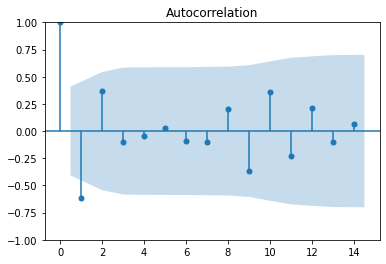

In [9]:
sm.graphics.tsa.plot_acf(gradients_seq[:, 0])
plt.show()

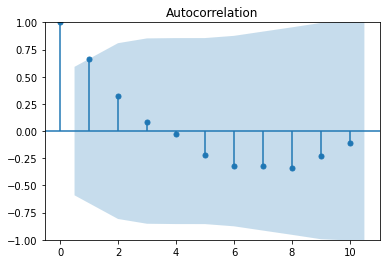

In [10]:
sm.graphics.tsa.plot_acf(gradients_seq[gradients_seq[:, 1] > 0][:, :1])
plt.show()

## Test on breast cancer dataset

In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score

data = load_breast_cancer()
y = data.target
X = data.data

clf = make_pipeline(StandardScaler(),
                    SGDClassifier(loss='log',max_iter=1000, tol=1e-3, verbose=0, learning_rate='constant', eta0=0.001))
clf.fit(X, y)
auc = roc_auc_score(y, clf.predict_proba(X)[:, 1])
print(auc)

0.9958511706569421


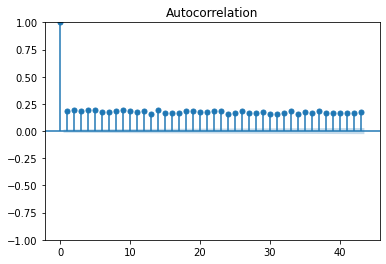

In [12]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

gradients_seq = clf['sgdclassifier'].weights_sequence[:clf['sgdclassifier'].n_iter_*len(X), :] \
                - clf['sgdclassifier'].weights_sequence[1:clf['sgdclassifier'].n_iter_*len(X)+1, :]
gradients_seq = gradients_seq[:-1]
sm.graphics.tsa.plot_acf(gradients_seq[:, 0])
plt.show()

In [13]:
ind_large_coef = np.argsort(abs(clf['sgdclassifier'].coef_[0]))[-5:]

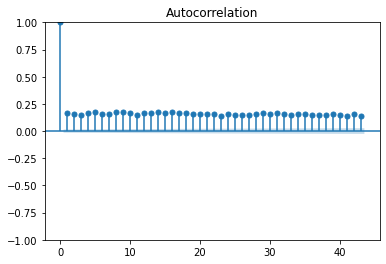

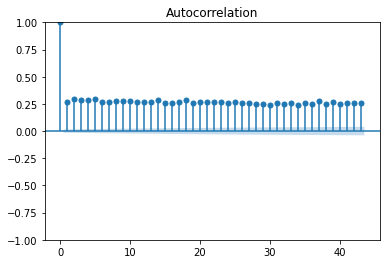

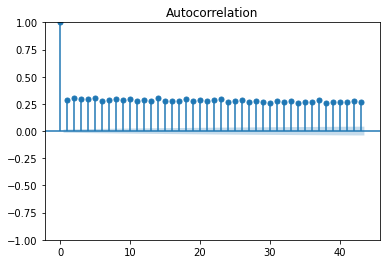

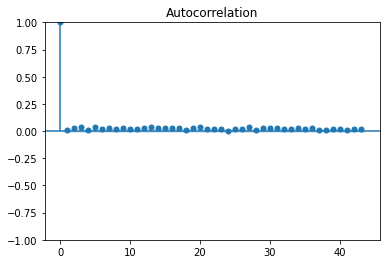

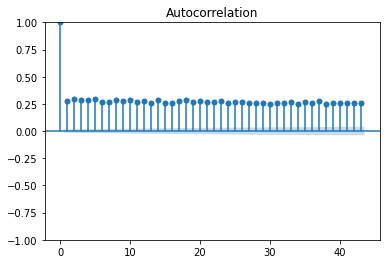

In [14]:
for coef in ind_large_coef:
    sm.graphics.tsa.plot_acf(gradients_seq[:, coef]) # [gradients_seq[:, coef] > 0]
    plt.show()

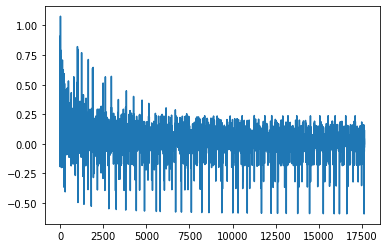

In [15]:
y = gradients_seq[:, ind_large_coef[-1]]
x = np.arange(len(y))

plt.plot(x, y)
plt.show()

### Cosine similarities

In [122]:
from scipy import spatial

dataSetI = [3, 45, 7, 2]
dataSetII = [2, 54, 13, 15]
result = 1 - spatial.distance.cosine(dataSetI, dataSetII)

In [126]:
gradients_0 = gradients_seq[:-1]
gradients_1 = gradients_seq[1:]
gradients_seq_pairs = list(zip(gradients_seq[:-1], gradients_seq[1:]))

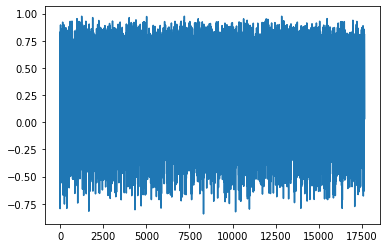

In [132]:
y = list(map(lambda x: 1 - spatial.distance.cosine(x[0], x[1]), gradients_seq_pairs))
x = np.arange(len(y))

plt.plot(x, y)
plt.show()

## Explore multiple loss and learning rates

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt


data = load_breast_cancer()
y = data.target
X = data.data
n_samples = len(X)
index_test = random.sample(range(n_samples), int(0.2 * n_samples))
index_train = [i for i in range(n_samples) if i not in index_test]
X_test = X[index_test, :]
y_test = y[index_test]
X = X[index_train, :]
y = y[index_train]

losses = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
learning_rates = {'constant': [0.1, 0.01, 0.001], 'optimal': [0.1], 'invscaling': [0.1, 0.01, 0.001], 'adaptive': [0.1, 0.01, 0.001]}

max_iter = 1000
tol = 1e-4
early_stopping = True
results = []

for loss in losses:
    for learning_rate in learning_rates.keys():
        for eta0 in learning_rates[learning_rate]:
            clf = make_pipeline(StandardScaler(),
                                SGDClassifier(loss=loss, max_iter=max_iter, tol=tol, verbose=0, learning_rate=learning_rate, eta0=eta0))
            clf.fit(X, y)
            auc = roc_auc_score(y_test, clf.decision_function(X_test))
            
            gradients_seq = clf['sgdclassifier'].weights_sequence[:clf['sgdclassifier'].n_iter_*len(X), :] \
                            - clf['sgdclassifier'].weights_sequence[1:clf['sgdclassifier'].n_iter_*len(X)+1, :]
            gradients_seq = gradients_seq[:-1]
            # compute acf for lag=1 on all features of the gradient
            acfs = [sm.tsa.stattools.acf(gradients_seq[:, i])[1] for i in range(gradients_seq.shape[1])]
            acf_max = np.max(acfs)
            acf_min = np.min(acfs)
            acf_mean = np.mean(acfs)
            acf_std = np.std(acfs)
            
            results.append({'loss': loss, 'learning_rate': learning_rate, 'eta0': eta0, 
                            'auc': auc, 'acf_max': acf_max, 'acf_min': acf_min,
                            'acf_mean': acf_mean, 'acf_std': acf_std})
            
df_results = pd.DataFrame.from_records(results)

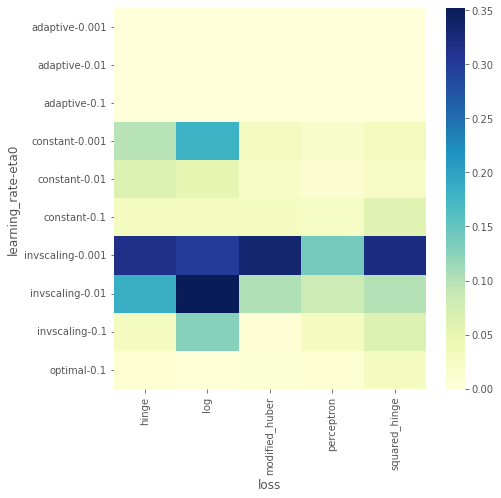

In [2]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

df_plot = df_results.set_index(['loss', 'learning_rate', 'eta0']).acf_max.unstack(level=0)
plt.figure(figsize=(7, 7))
ax = sns.heatmap(df_plot, cmap="YlGnBu")
plt.show()

* measure on biggest coef (log reg)
* measure after lasso
* measure with "rolling acf" from start to end of training
* tune number of samples in sgd

* acf for near optimal lr
* check how much acf is needed to get reasonnable improvement in dp
* transfer to py

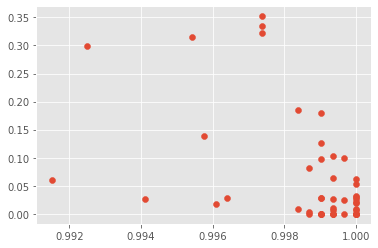

In [3]:
df_plot = df_results.loc[df_results.auc >= df_results.auc.max()*(1-0.1)]
plt.scatter(df_plot.auc, df_plot.acf_max)
plt.show()

## Plain gradient descent

In [129]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
import copy

data = load_breast_cancer()
y = data.target
X = data.data
n_samples = len(X)
index_test = random.sample(range(n_samples), int(0.1 * n_samples))
index_train = [i for i in range(n_samples) if i not in index_test]
X_test = X[index_test, :]
y_test = y[index_test]
X = X[index_train, :]
y = y[index_train]

scaler = StandardScaler()
clf = SGDClassifier(loss='hinge', learning_rate='optimal', eta0=0.01, warm_start=True, penalty='l1')
X = scaler.fit_transform(X)

coefs = []
etas = []
n_epochs = 100
for _ in range(n_epochs):
    clf.partial_fit(X, y, classes=np.unique(y))
    coefs.append(copy.copy(clf.coef_))
    etas.append(copy.copy(clf.eta))

auc = roc_auc_score(y_test, clf.decision_function(scaler.transform(X_test)))
print(auc)

0.9947916666666667


In [130]:
coefs = np.array(list(map(lambda x: x.ravel(), np.array(coefs))))
dif_coef = coefs[:-1] - coefs[1:]
grad_seq = -np.array([dif_coef[i] / etas[i] for i in range(len(dif_coef))])

In [131]:
acfs = [sm.tsa.stattools.acf(grad_seq[:, i])[1] for i in range(grad_seq.shape[1])]
acf_max = np.max(acfs)
acf_min = np.min(acfs)
acf_mean = np.mean(acfs)
acf_std = np.std(acfs)

In [132]:
print(acf_max, acf_min, acf_mean, acf_std)

-0.15580922431518288 -0.5148082573882952 -0.3608698938836168 0.09089423033971304


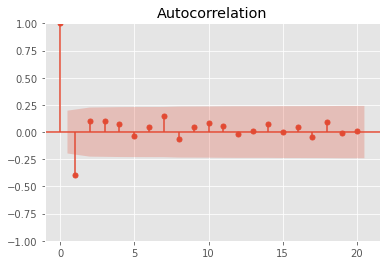

In [135]:
sm.graphics.tsa.plot_acf(grad_seq[:, 10]) # [gradients_seq[:, coef] > 0]
plt.show()

## Toy dataset 1dimension

MSE: 24.788442563748667


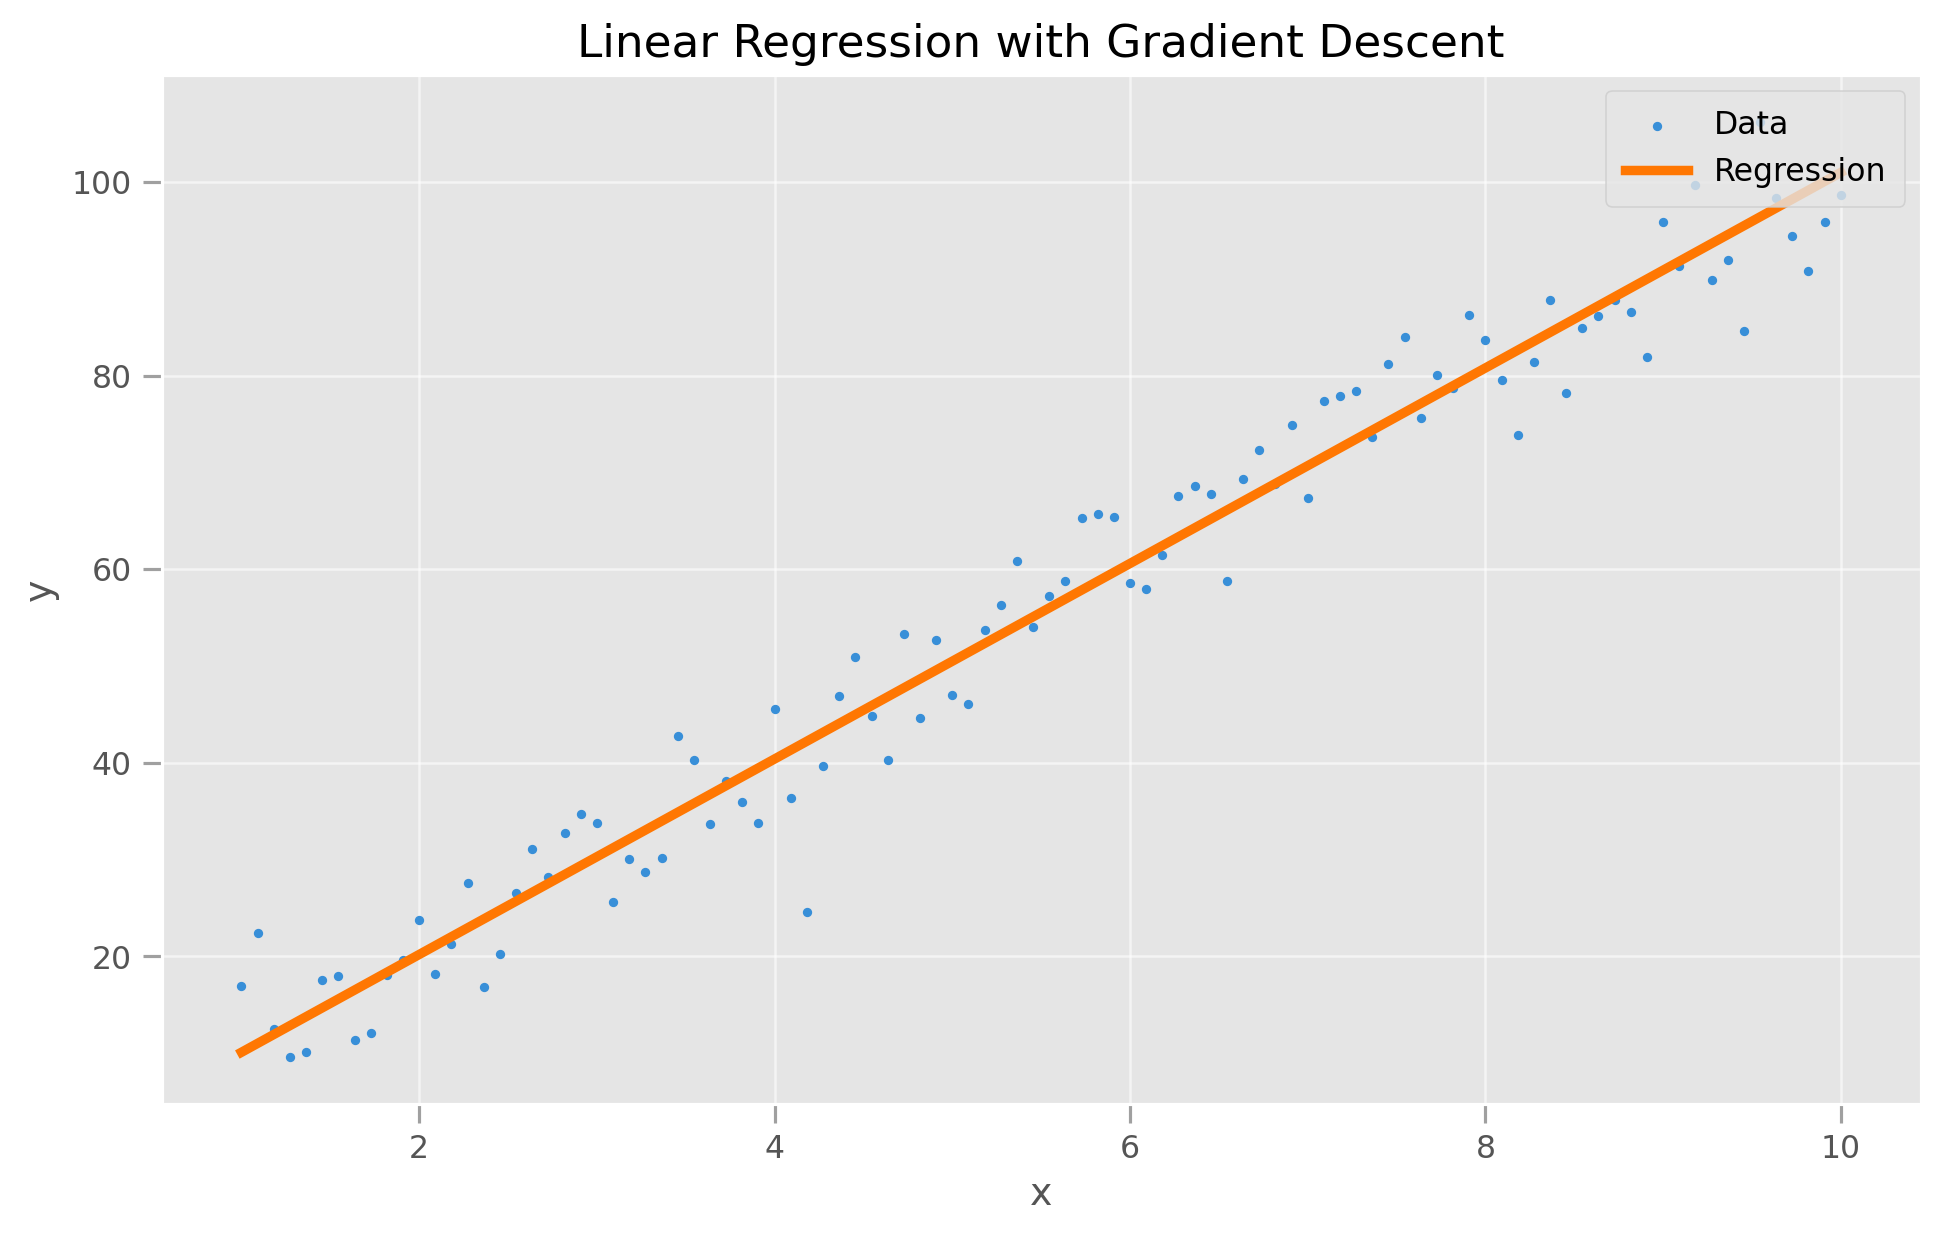

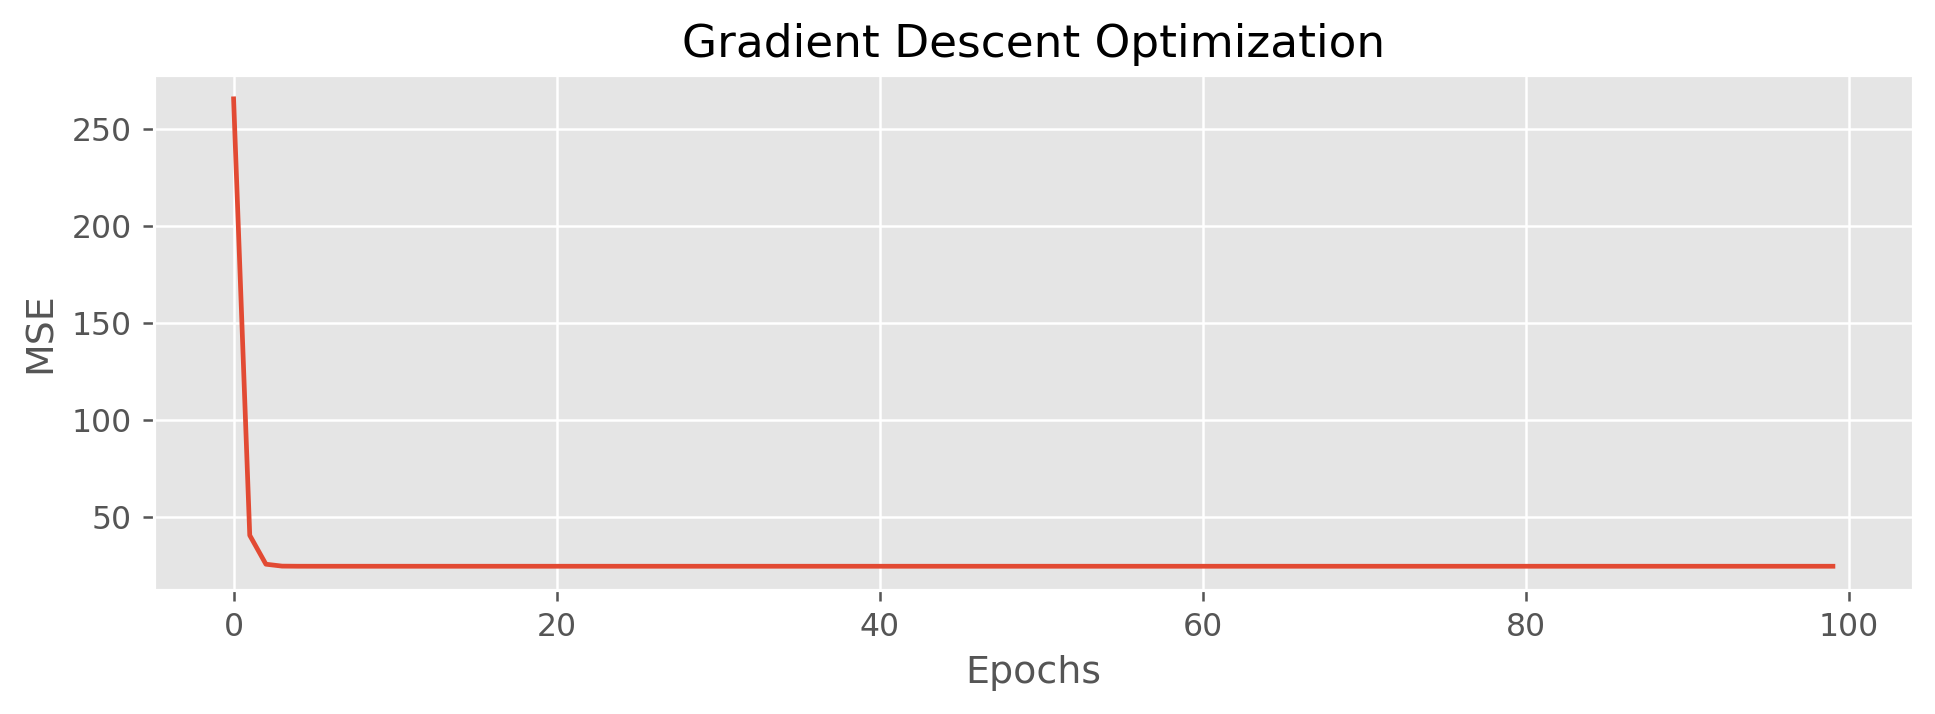

In [34]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

n_samples = 100
x = np.linspace(1, 10, n_samples)
y = 10*x + 5*np.random.randn(n_samples)
X = x.reshape(-1, 1)
y = y.reshape(-1, 1)

def gradient_descent(X, y, lr=0.05, epoch=10):
    
    '''
    Gradient Descent for a single feature
    '''
    
    m, b = 0.2, 0 # parameters, no intercept
    log, mse, grad_seq = [], [], [] # lists to store learning process
    N = len(X) # number of samples
    
    for _ in range(epoch):
                
        f = y - m*X
    
        # Updating m
        grad = -2 * X.T.dot(f) / N
        m -= lr * grad
        
        grad_seq.append(grad)
        log.append((m, b))
        mse.append(((y - (m*X + b))**2).mean())        
    
    return m, b, log, mse, grad_seq

m, b, log, mse, grad_seq = gradient_descent(X, y, lr=0.01, epoch=100)

y_pred = m*X + b


def plot_regression(X, y, y_pred, log=None, title="Linear Regression"):
    
    plt.figure(figsize=(10,6))
    plt.rcParams['figure.dpi'] = 227
    plt.scatter(X, y, label='Data', c='#388fd8', s=6)
    if log != None:
        for i in range(len(log)):
            plt.plot(X, log[i][0]*X + log[i][1], lw=1, c='#caa727', alpha=0.9)
    plt.plot(X, y_pred, c='#ff7702', lw=1, label='Regression')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
    plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
    plt.show()

print("MSE:", ((y - (y_pred))**2).mean())
plot_regression(X, y, y_pred, log=log, title="Linear Regression with Gradient Descent")

plt.figure(figsize=(10,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(mse)), mse)
plt.title('Gradient Descent Optimization')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [25]:
X.T.dot(X)

array([[3713.63636364]])